# Thunderbird 2 supercomputer logs EDA

## Introduction
This notebook contains exploratory data analysis of Thunderbird 2 supercomputer logs that is a part of CFDR data (see https://www.usenix.org/cfdr-data). CFDR data contains logs of 22 high-performance computing systems. The workloads run on those systems are large-scale long-running 3D scientific simulations, e.g. for nuclear stockpile stewardship. 

Original dataset used for extracting the sample under analysis is a raw text file containing event logs collected between 2004 and 2006 containing alert and non-alert messages identified by alert category tags. Thunderbird supercomputer logs dataset is suitable for alert detection and prediction research.

## The data set overview
Thunderbird original logs contain 211,212,192 messages, where 3,248,239 of them are related to 10 categories of alerts.  Non-alert messages are starting with "-" mark.

The logs were collected using UDP protocol for transmission. Some alert messages are missing in sample records that was caused by network connection interruption.

The data sample used for further analysis is extracted from the original one as a random subsample containing 0,5% of records.

More detailed dataset description can be found in the paper written by Adam Oliner and Jon Stearley [1].

## References
1. Oliner, Adam & Stearley, Jon. (2007). What Supercomputers Say: A Study of Five System Logs. 575-584. 10.1109/DSN.2007.103. 


# Exploratory data analysis

## I. The dataset overview and preprocessing



Load the dataset:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import gc

data = pd.read_csv("../data/tbird2_sample.csv")
data.head()

,alert_class,message_id,date,host_name,month,day,time,host_privilege,tool,message
0,-,1136327431,2006.01.03,an922,Jan,3,14:30:31,an922/an922,smartd[1976]:,Configuration file /etc/smartd.conf parsed.
1,-,1135346286,2005.12.23,dn669,Dec,23,05:58:06,dn669/dn669,crond[1281]:,(root) CMD (run-parts /etc/cron.hourly)
2,-,1136415929,2006.01.04,bn948,Jan,4,15:05:29,bn948/bn948,kernel:,Probing IDE interface ide4...
3,-,1134356625,2005.12.11,an212,Dec,11,19:03:45,an212/an212,Server,Administrator: Instrumentation Service EventID...
4,-,1135321264,2005.12.22,an23,Dec,22,23:01:04,an23/an23,crond(pam_unix)[6624]:,session closed for user root


Let's take an overview of alert categories:

In [2]:
data.alert_class.value_counts()

-                 219653
R_VAPI              7705
R_MTT               2140
N_CALL_TR            146
R_SCSI1                8
N_NFS                  5
R_MPT                  4
R_EXT_FS_ABRT2         3
R_EXT_FS_ABRT1         1
R_SCSI0                1
R_EXT_INODE2           1
Name: alert_class, dtype: int64

The sample contains 219653 non-alert messages, that is the majority of records.
R_EXT_FS_ABRT2, R_EXT_FS_ABRT1, and R_EXT_INODE2 are related to one type of alert - EXT.
R_SCSI1, R_SCSI0 are related to one type of alert - SCSI.

All log types are encoded as follows:

In [3]:
log_type_dict = {'-':0, 'R_VAPI':1, 'R_MTT':2, 'N_CALL_TR':3, 'R_SCSI1':4, 'R_SCSI0': 4, 'N_NFS':5, 'R_MPT':6,
                 'R_EXT_FS_ABRT2':7, 'R_EXT_FS_ABRT1':7, 'R_EXT_INODE2':7}

data['alert_class'] = data['alert_class'].replace(log_type_dict, regex=True)

data.alert_class.value_counts()

0    219653
1      7705
2      2140
3       146
4         9
7         5
5         5
6         4
Name: alert_class, dtype: int64

Frequency distribution of alert and non-alert messages:

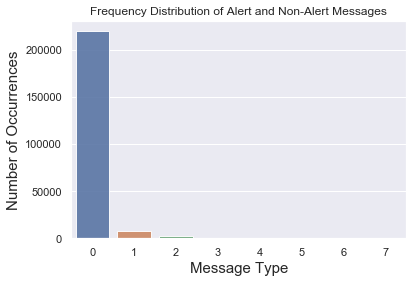

In [4]:
%matplotlib inline
count = data['alert_class'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of Alert and Non-Alert Messages')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Message Type', fontsize=15)
plt.show()

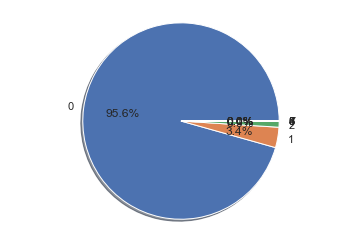

In [5]:
labels = data['alert_class'].astype('category').cat.categories.tolist()
counts = data['alert_class'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

Extract new timeseries features from datetime and time columns:

In [6]:
data["date"] = pd.to_datetime(data["date"])
data['month'] = data['date'].dt.month
data['year']  = data['date'].dt.year
data['weekday'] = data['date'].dt.weekday
data.drop(['date'], 1, inplace=True)
data.head()

,alert_class,message_id,host_name,month,day,time,host_privilege,tool,message,year,weekday
0,0,1136327431,an922,1,3,14:30:31,an922/an922,smartd[1976]:,Configuration file /etc/smartd.conf parsed.,2006,1
1,0,1135346286,dn669,12,23,05:58:06,dn669/dn669,crond[1281]:,(root) CMD (run-parts /etc/cron.hourly),2005,4
2,0,1136415929,bn948,1,4,15:05:29,bn948/bn948,kernel:,Probing IDE interface ide4...,2006,2
3,0,1134356625,an212,12,11,19:03:45,an212/an212,Server,Administrator: Instrumentation Service EventID...,2005,6
4,0,1135321264,an23,12,22,23:01:04,an23/an23,crond(pam_unix)[6624]:,session closed for user root,2005,3


In [ ]:
temp = pd.to_datetime(data["time"])
data['hour'] = temp.dt.hour
data['minute'] = temp.dt.minute
data['second'] = temp.dt.second
data.drop(['time'], 1, inplace=True)
del temp
gc.collect;

data.head()

Investigate **tool** feature:

In [ ]:
data['tool'].value_counts()

Processes names are in the following forms:
1. ***process_name:***
2. ***process_name [process_id]:***
3. ***process_name(authentication_module) [process_id]:***


In [ ]:
# data['authentication'] = 

## II. Missing entries overview

In [ ]:
data.isnull().sum()

850 entries have logs with lost messages. As the message was missing due to the connection failure, all missing values are going to be replaced with 'Connection failure' message.

In [ ]:
data['message'].fillna("Connection failure", inplace = True)
data.isnull().sum()

## III. Feature engineering



## IV. Features correlation heatmap

In [19]:
data.head()

,alert_class,host_name,month,day,host_privilege,tool,message,year,weekday,hour,minute,second
0,0,an922,1,3,an922/an922,smartd[1976]:,Configuration file /etc/smartd.conf parsed.,2006,1,14,30,31
1,0,dn669,12,23,dn669/dn669,crond[1281]:,(root) CMD (run-parts /etc/cron.hourly),2005,4,5,58,6
2,0,bn948,1,4,bn948/bn948,kernel:,Probing IDE interface ide4...,2006,2,15,5,29
3,0,an212,12,11,an212/an212,Server,Administrator: Instrumentation Service EventID...,2005,6,19,3,45
4,0,an23,12,22,an23/an23,crond(pam_unix)[6624]:,session closed for user root,2005,3,23,1,4


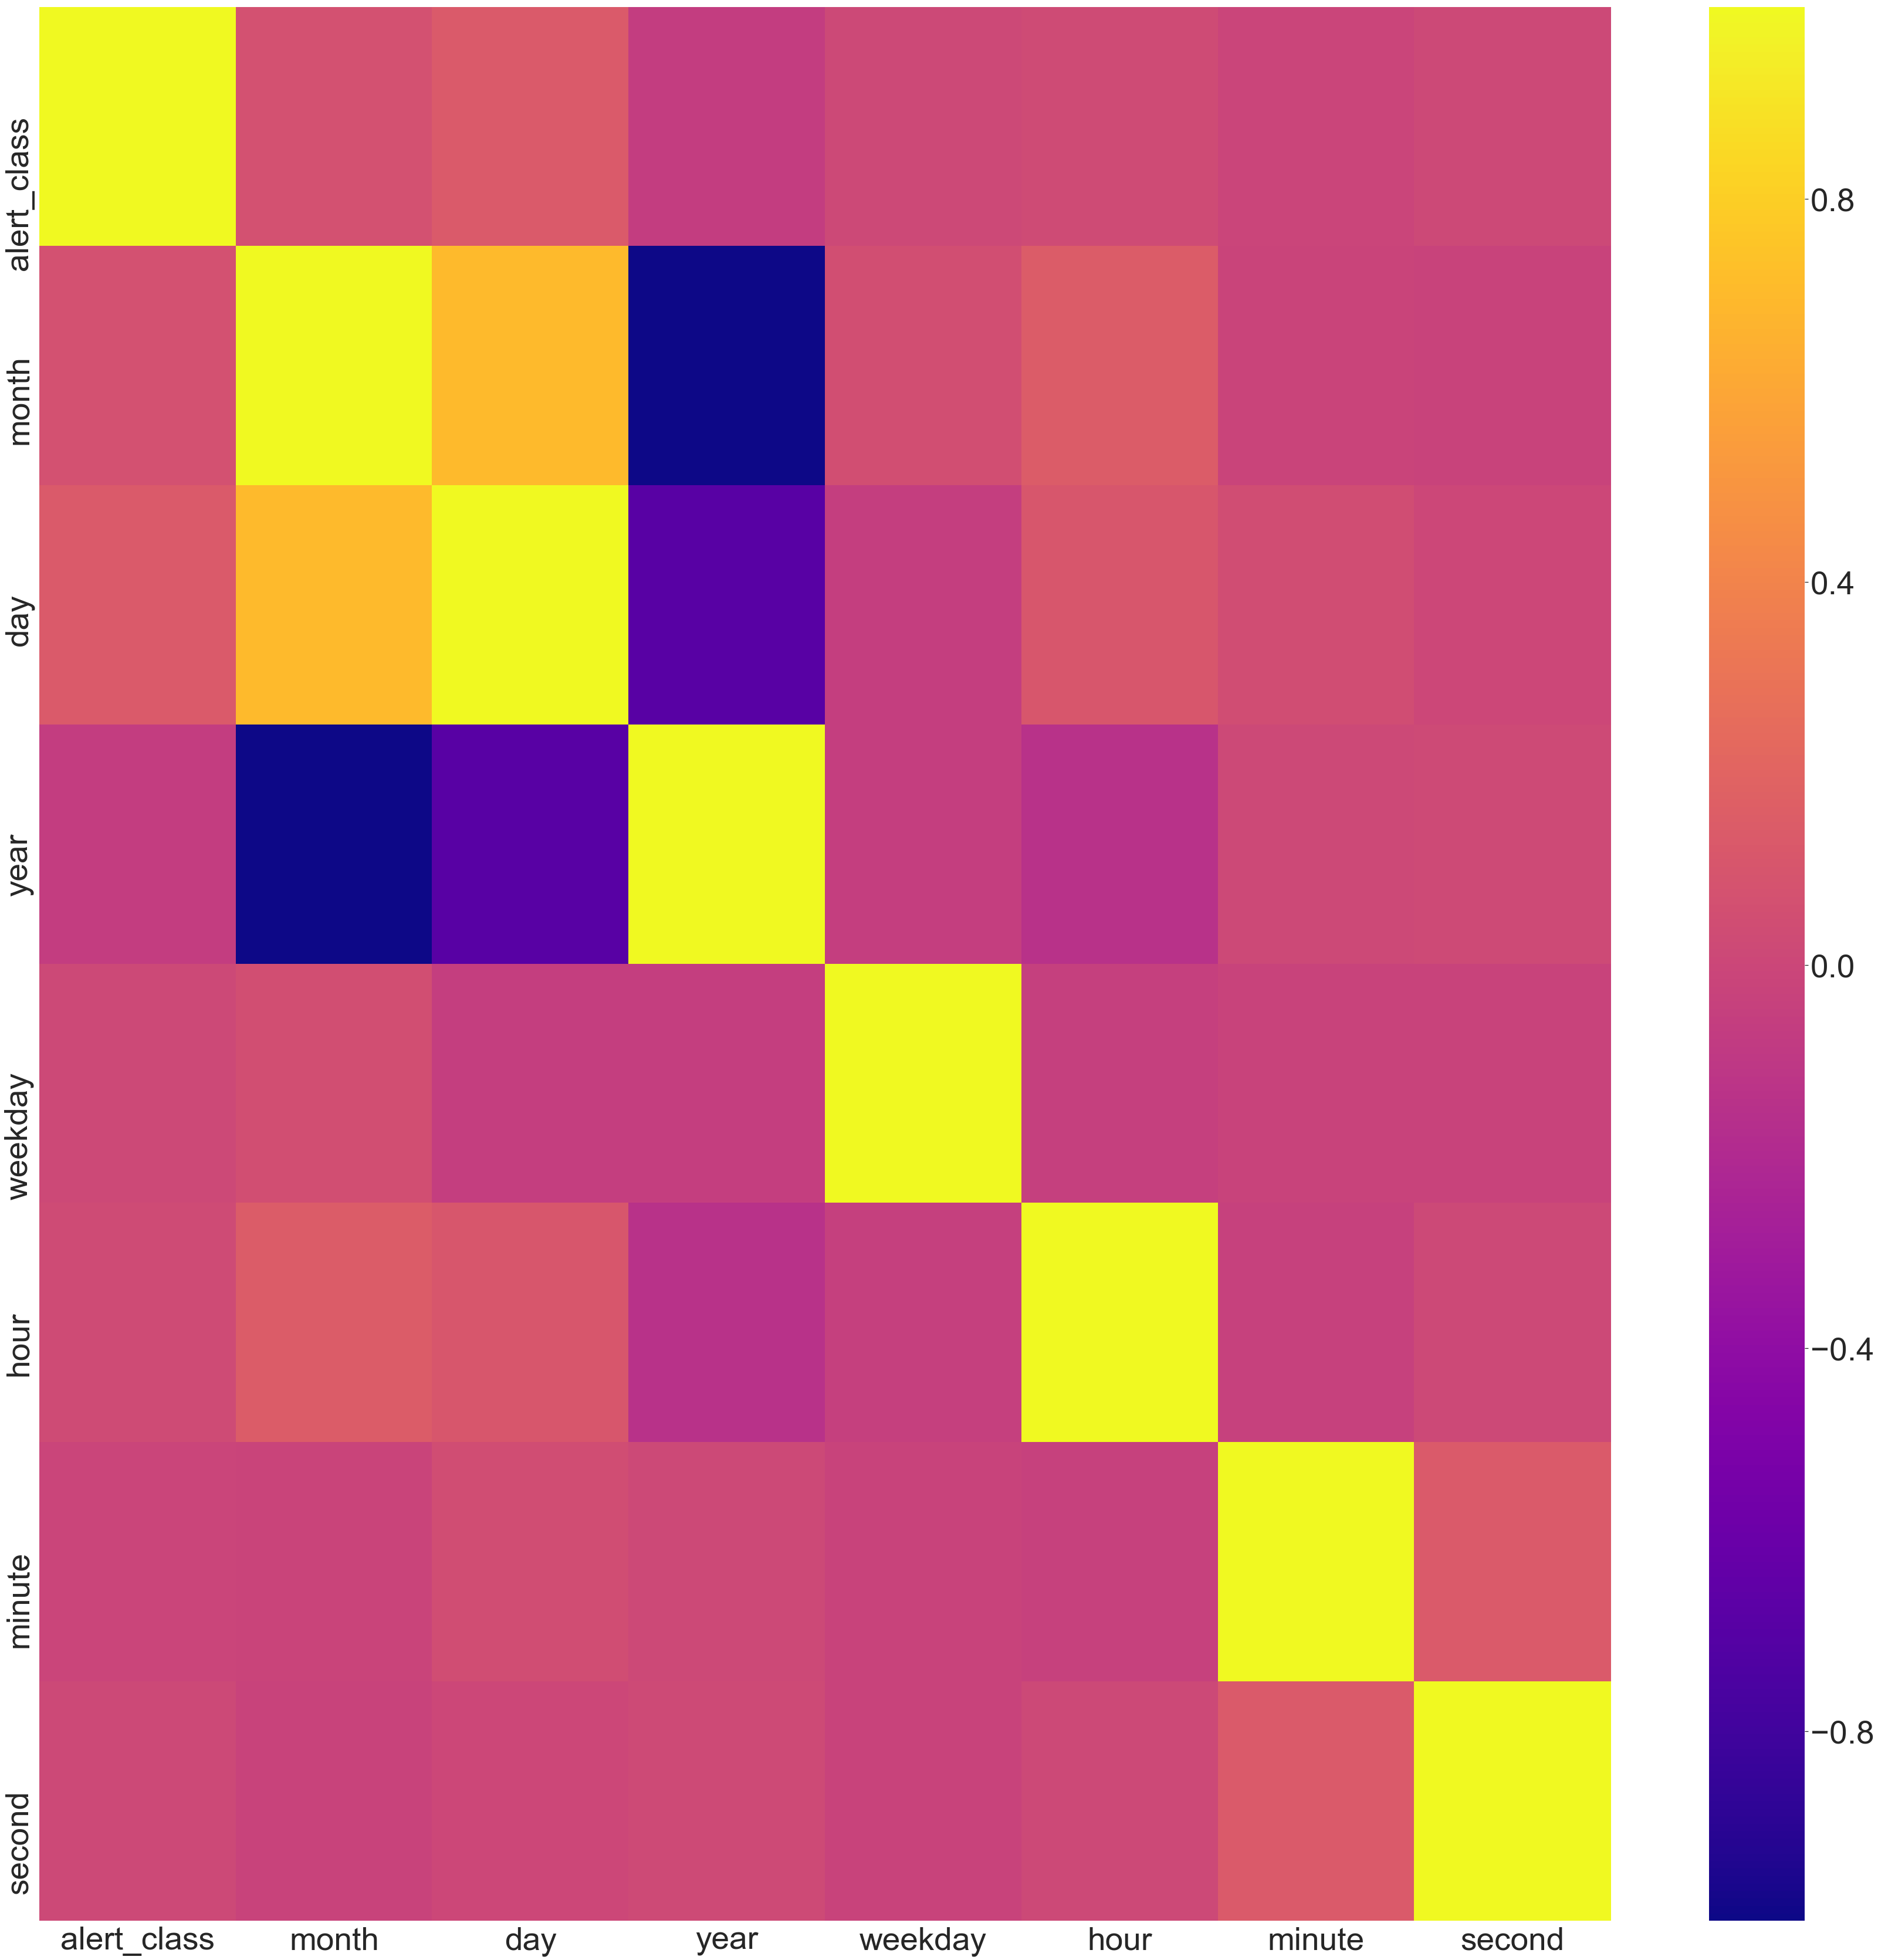

In [20]:
fig, ax = plt.subplots(figsize=(60, 60))
sns.set(font_scale=5)
features = data.loc[:, data.columns != 'message_id']
correlation_matrix = features.corr(method='pearson', min_periods=1)
sns.heatmap(correlation_matrix, ax=ax, cmap="plasma", fmt="d")
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()